<center><h1>Saravanan_Praveen_HW6</h1></center>

Name: Praveen Saravanan
<br>
Github Username: Michael-on-the-Microphone
<br>
USC ID: 7939976839

## 1. Tree-Based Methods

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, precision_recall_fscore_support)
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
pd.set_option('future.no_silent_downcasting', True)

### (a) Download the APS Failure data

In [2]:
train_path = "../data/aps_failure_training_set.csv"
test_path  = "../data/aps_failure_test_set.csv"

train_raw = pd.read_csv(train_path, skiprows=20, na_values='na')
test_raw  = pd.read_csv(test_path, skiprows=20,  na_values='na')

print(train_raw.shape, test_raw.shape)
train_raw.head()

imputer = SimpleImputer(strategy="median")
X_train_imp = pd.DataFrame(imputer.fit_transform(train_raw.drop('class', axis=1)), columns=train_raw.columns.drop('class'))
y_train = train_raw['class'].replace({'neg':0, 'pos':1}).astype(int)

X_test_imp = pd.DataFrame(imputer.transform(test_raw.drop('class', axis=1)), columns=test_raw.columns.drop('class'))
y_test = test_raw['class'].replace({'neg':0, 'pos':1}).astype(int)

(60000, 171) (16000, 171)


### (b) Data Preparation

#### (i) Research what types of techniques are usually used

* Statistical imputation (mean/median). Replace missing numeric values with the column’s mean or median.
* K-nearest neighbors imputation (KNNImputer). Estimate each missing entry from the values of the most similar rows.
* Multivariate Imputation by Chained Equations (MICE). Iteratively model each feature with missing data as a function of the others, repeating several times and pooling the results.
* Mode or constant imputation. Fill missing entries with the most frequent value in the column or with a fixed constant (works for both numeric and categorical data).

For this assignment, I filled all missing entries using each column’s mean, after first converting every value to a numeric type.

#### (ii) Calculate the coefficient of variation

In [3]:
feature_cols = train_raw.columns.drop('class')

X_train_imp = pd.DataFrame(imputer.fit_transform(train_raw[feature_cols]), columns=feature_cols, index=train_raw.index)

cv_results = {}
for col in X_train_imp.columns:
    mu = X_train_imp[col].mean()
    sigma = X_train_imp[col].std(ddof=0)       
    cv = sigma / mu if mu != 0 else np.nan     
    cv_results[col] = [mu, sigma, cv]

coefficient_of_variation = pd.DataFrame(cv_results, index=['mu', 'std', 'cv'])
display(coefficient_of_variation)

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
mu,59336.499567,0.162500,3.362258e+08,1.434383e+05,6.535000,10.548200,219.157733,964.810433,8509.770600,87600.535267,...,4.431223e+05,210018.844967,4.432268e+05,3.916653e+05,3.303672e+05,3.428586e+05,137221.150400,8295.098600,0.086467,0.203100
std,145428.844609,1.687304,7.767561e+08,3.504496e+07,158.146575,205.385403,20363.474882,34008.622058,149480.594394,757510.772889,...,1.149266e+06,540368.040753,1.161992e+06,1.114955e+06,1.063457e+06,1.718651e+06,447210.810467,47212.091891,4.268535,8.627971
cv,2.450917,10.383407,2.310221e+00,2.443208e+02,24.199935,19.471133,92.916981,35.249020,17.565761,8.647330,...,2.593564e+00,2.572950,2.621665e+00,2.846704e+00,3.219014e+00,5.012712e+00,3.259052,5.691565,49.366248,42.481393


#### (iii) Plot a correlation matrix

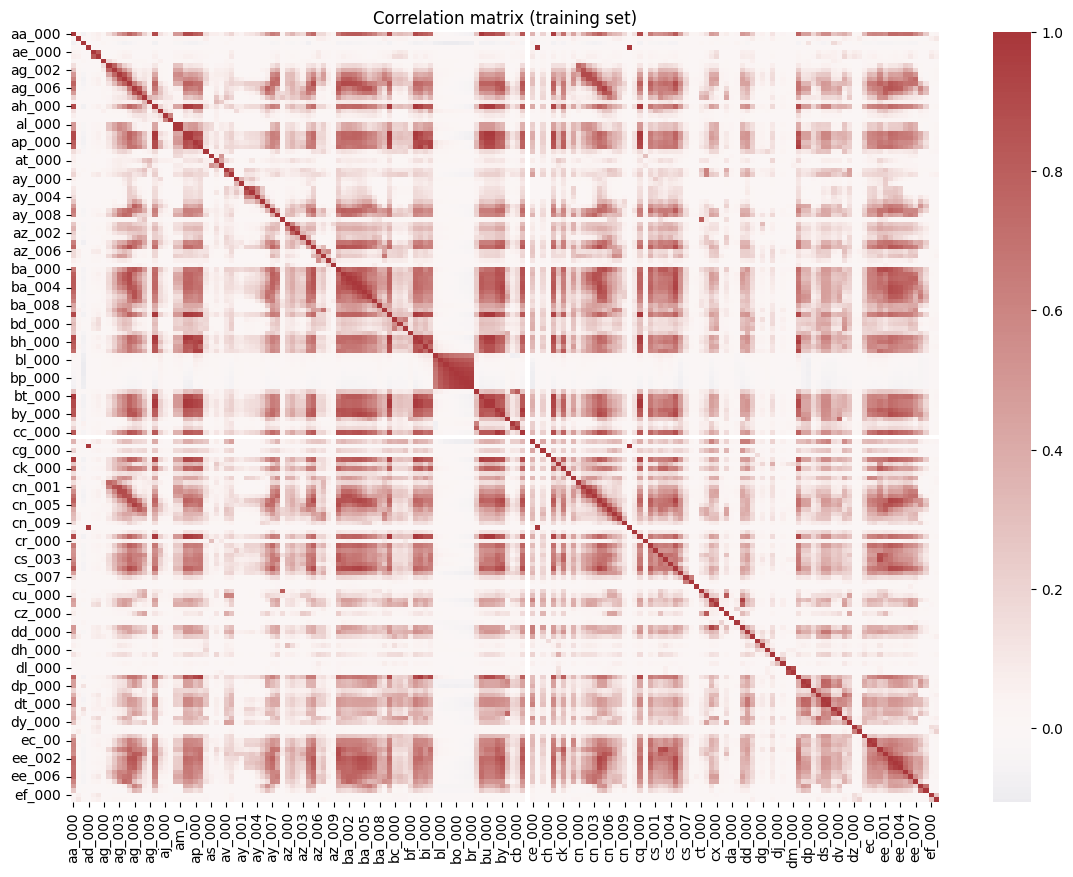

In [4]:
plt.figure(figsize=(14,10))
sns.heatmap(X_train_imp.corr(), cmap="vlag", center=0, linewidth=0)
plt.title("Correlation matrix (training set)")
plt.show()

#### (iv) Make scatter plots and box plots

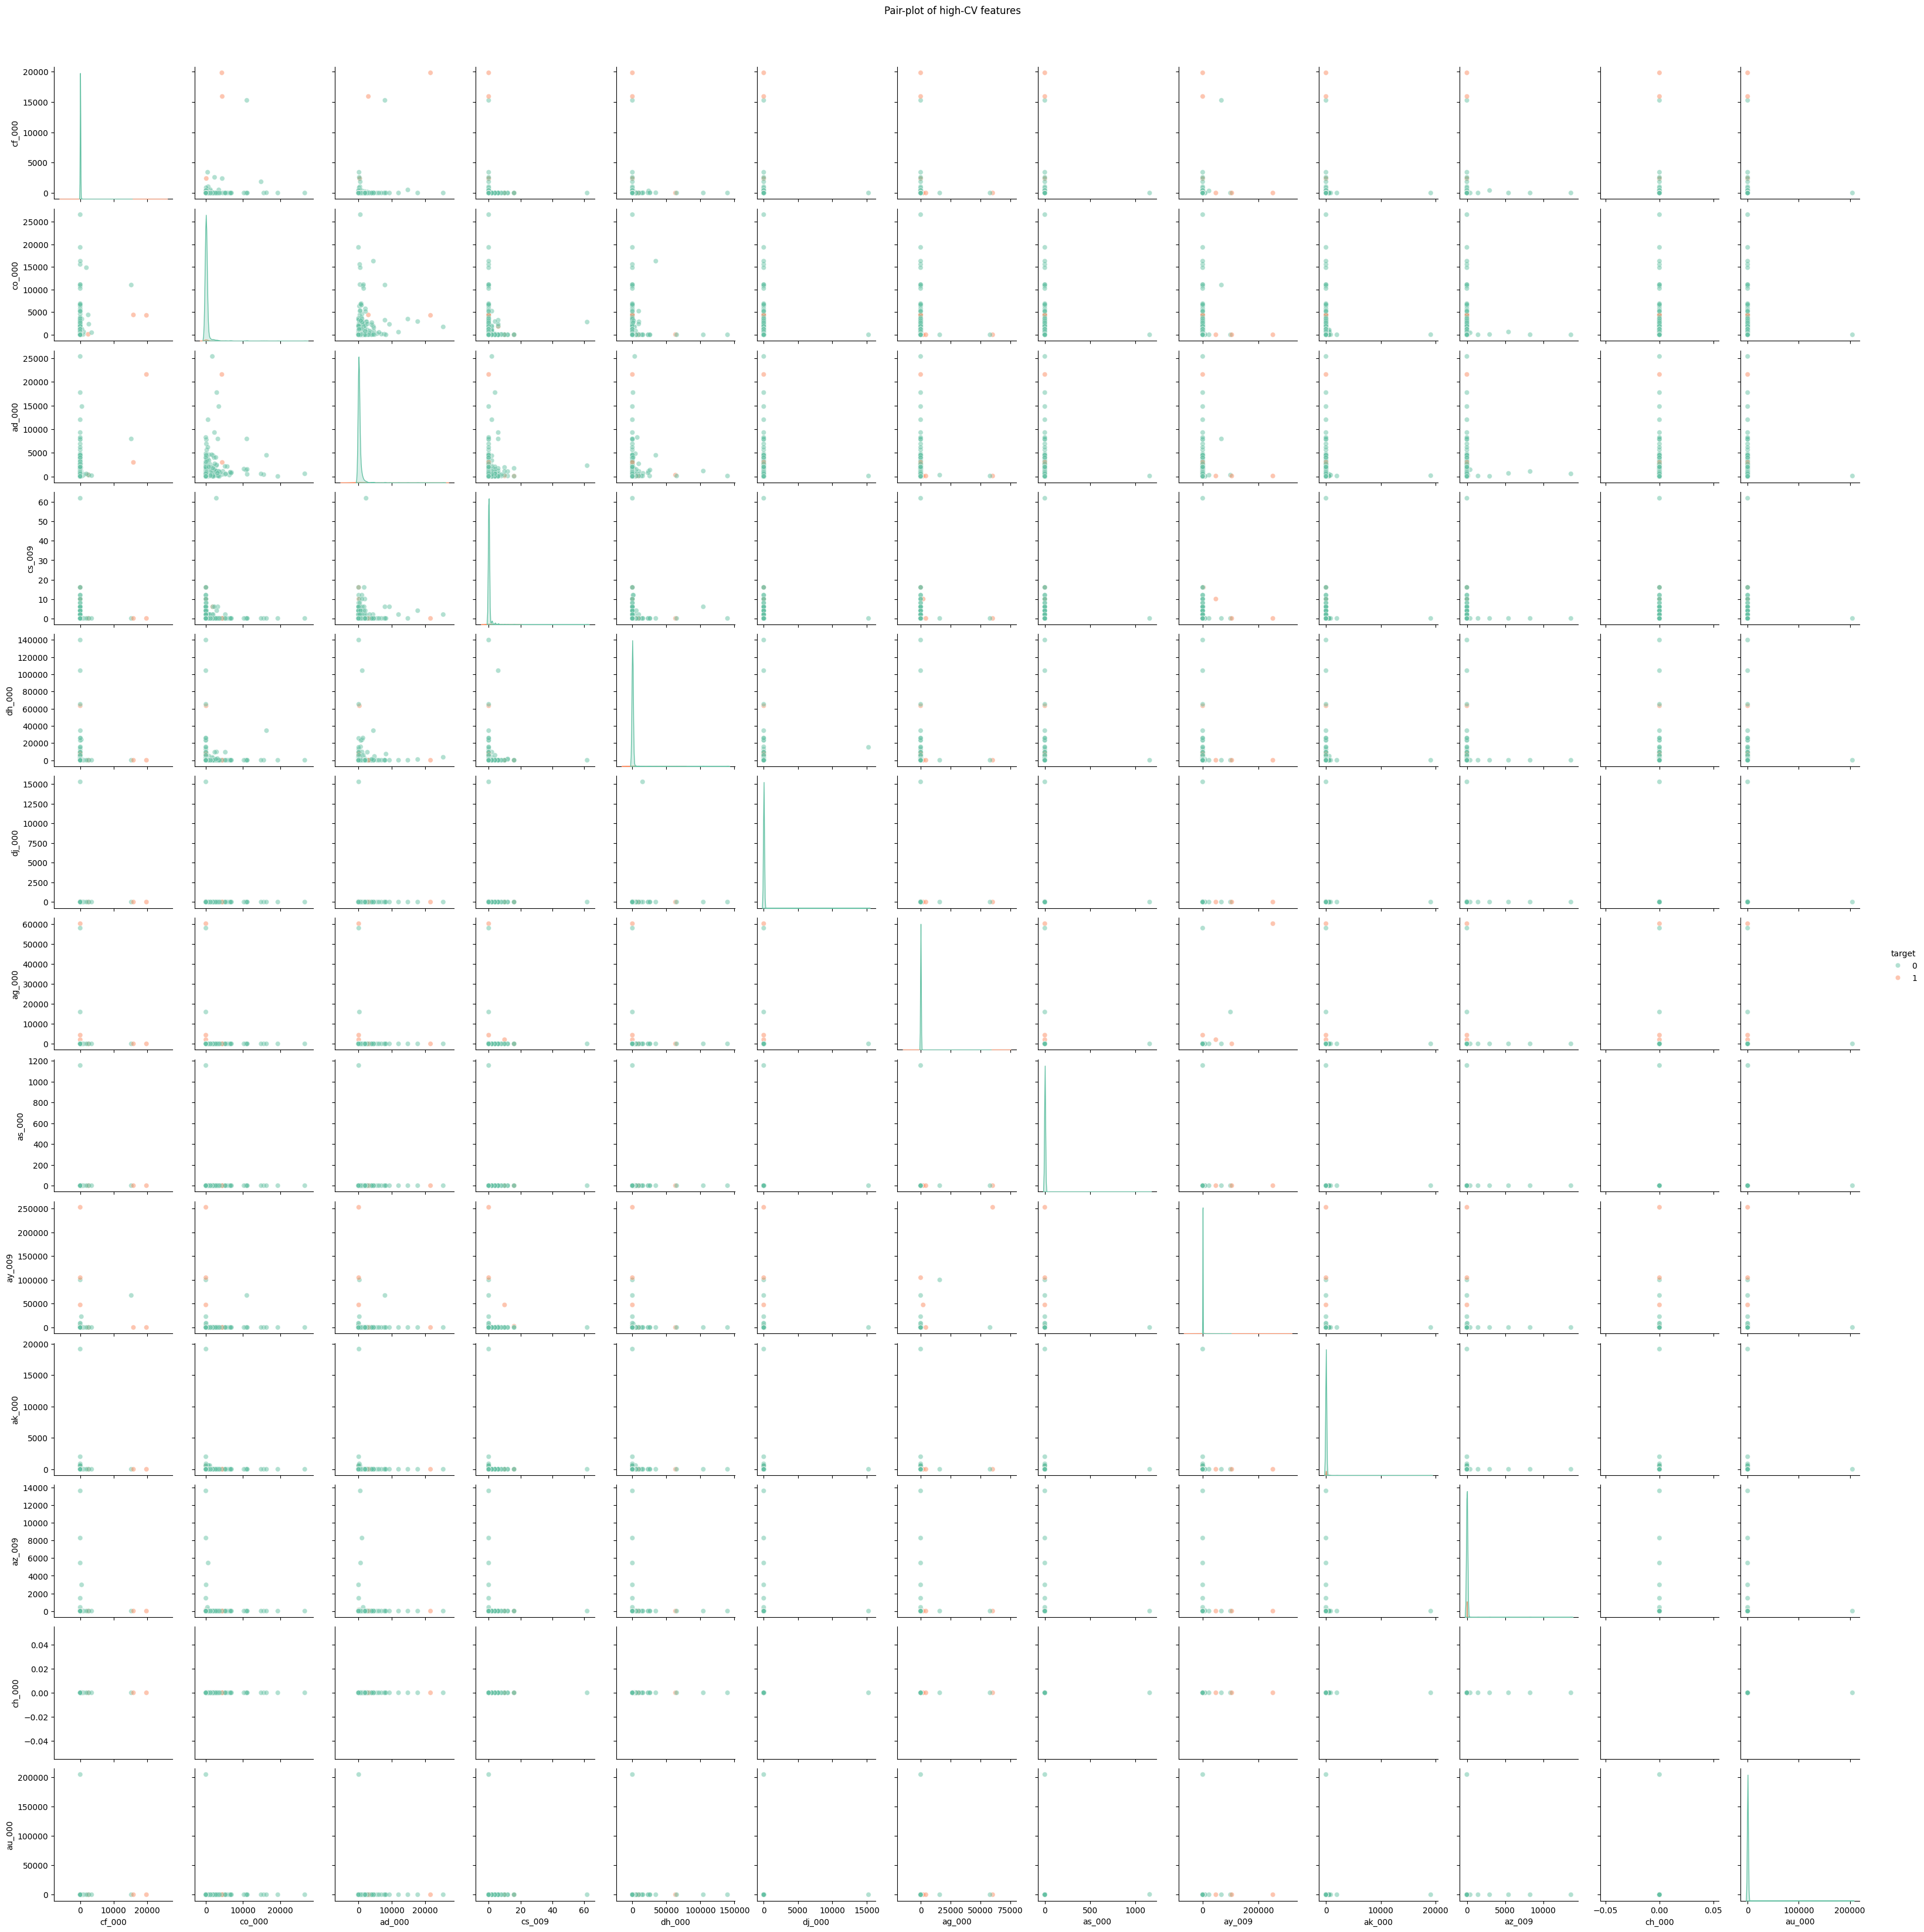

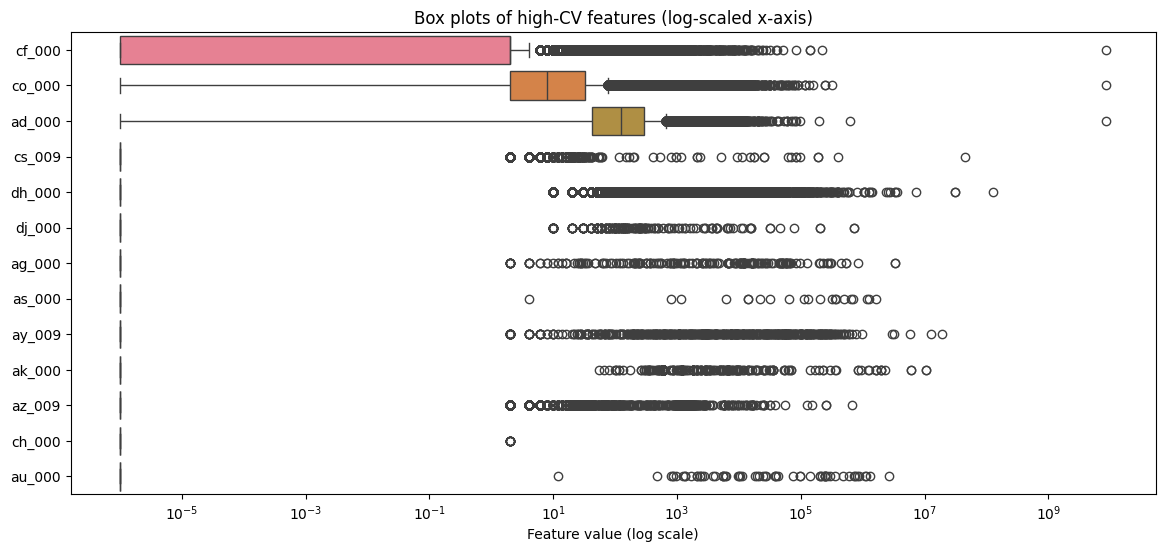

In [5]:
topk = coefficient_of_variation.loc['cv'].sort_values(ascending=False).head(13).index.tolist()

sample = X_train_imp[topk].copy()          
sample['target'] = y_train                
sample = sample.sample(n=2000, random_state=42) 


sns.pairplot(sample, hue="target", palette="Set2", plot_kws=dict(alpha=.5))
plt.suptitle("Pair-plot of high-CV features", y=1.02)
plt.show()

plt.figure(figsize=(14,6))
eps = 1e-6
sns.boxplot(data=X_train_imp[topk] + eps, orient="h")
plt.xscale("log")
plt.title("Box plots of high-CV features (log-scaled x-axis)")
plt.xlabel("Feature value (log scale)")
plt.show()


**Conclusion:**
The scatter-plots alone don’t reveal clear class separation, so we can’t make firm claims about feature significance from them. Because I used mean imputation, any extreme outliers could still skew the data and further blur visual patterns.

#### (v) Is this data set imbalanced?

In [6]:
print("Training distribution:\n", y_train.value_counts())
print("Test distribution:\n", y_test.value_counts())
imbalance_ratio = y_train.value_counts(normalize=True)
print(f"Positive class proportion: {imbalance_ratio[1]:.4f}")

Training distribution:
 class
0    59000
1     1000
Name: count, dtype: int64
Test distribution:
 class
0    15625
1      375
Name: count, dtype: int64
Positive class proportion: 0.0167


1.67 percent positive class indicates this is highly imbalenced data!

### (c) Train a random forest

OOB error: 0.005800000000000027
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

[[15606    19]
 [  103   272]]
Test AUC: 0.9943119360000001


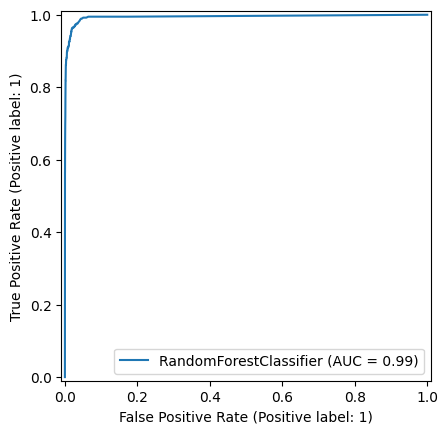

In [7]:
rf = RandomForestClassifier(
        n_estimators=500,
        n_jobs=-1,
        oob_score=True,
        random_state=42)

rf.fit(X_train_imp, y_train)

print("OOB error:", 1 - rf.oob_score_)
print(classification_report(y_train, rf.predict(X_train_imp)))

y_pred = rf.predict(X_test_imp)
print(confusion_matrix(y_test, y_pred))

print("Test AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_imp)[:,1]))
RocCurveDisplay.from_estimator(rf, X_test_imp, y_test)
plt.show()

* The random forest’s OOB error is only **0.0058**, indicating it fits the training data almost perfectly.
* Training metrics are near-ideal (precision, recall, and F1 all ≈ 1.00), but the **test confusion matrix shows 103 false negatives and 19 false positives**.
* Because the positive class is so rare, the model focuses mainly on learning the dominant negative class, which leads to more missed positives (higher FN) at test time.
* Despite this skew, the overall test **AUC remains high at 0.994**, confirming strong ranking ability; the gap between train and test performance is driven primarily by the class imbalance rather than model capacity.

### (d) Research class imbalance in random forest

Two common ways to address class imbalance in random-forest models:

* **RandomForestClassifier with class_weight='balanced'.**
  Assigns each class a weight inversely proportional to its frequency—`{class_label: weight}`—so the minority class exerts more influence during tree construction. (For multi-output targets you pass a list of such dictionaries.)

* **BalancedRandomForestClassifier.**
  A variant from `imblearn` that draws a bootstrap sample with random under-sampling of the majority class at every tree, yielding a more balanced training subset for each estimator.


In [8]:
rf_bal = RandomForestClassifier(
            n_estimators=500,
            class_weight='balanced_subsample',   
            n_jobs=-1,
            oob_score=True,
            random_state=42)

rf_bal.fit(X_train_imp, y_train)

print("Balanced RF - OOB error:", 1 - rf_bal.oob_score_)
print(confusion_matrix(y_test, rf_bal.predict(X_test_imp)))
print("Balanced RF - Test AUC:",
      roc_auc_score(y_test, rf_bal.predict_proba(X_test_imp)[:,1]))

Balanced RF - OOB error: 0.007349999999999968
[[15610    15]
 [  155   220]]
Balanced RF - Test AUC: 0.9932882773333334


Re-weighting (or undersampling) doesn’t guarantee higher minority-class recall; it shifts the bias-variance trade-off. Here the balanced RF produced fewer false alarms but missed more actual failures, delivering nearly the same AUC but a different error profile. Further tuning (threshold adjustment, cost-sensitive metrics, or SMOTE + XGBoost) may recover the lost recall while keeping precision in check.

### (e) XGBoost and Model Trees

Best reg_alpha: 10
XGB Test AUC: 0.9968933546666666


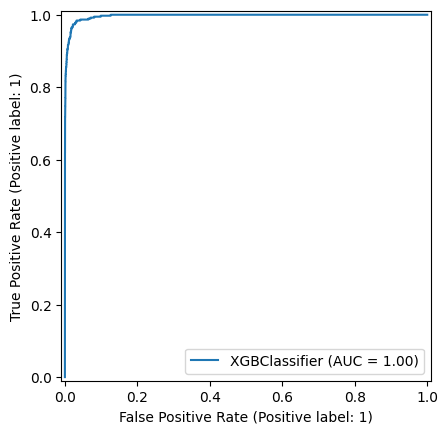

In [9]:
xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',      
        reg_alpha=1.0,              
        reg_lambda=0.0,
        n_estimators=600,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42)

param_grid = {'reg_alpha': [0, 0.1, 1, 5, 10]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for a in param_grid['reg_alpha']:
    xgb.set_params(reg_alpha=a)
    auc = cross_val_score(
            xgb, X_train_imp, y_train, 
            cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_scores.append((a, auc.mean()))
    
best_alpha = max(cv_scores, key=lambda t: t[1])[0]
print("Best reg_alpha:", best_alpha)

# Train final model
xgb.set_params(reg_alpha=best_alpha)
xgb.fit(X_train_imp, y_train)

print("XGB Test AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test_imp)[:,1]))
RocCurveDisplay.from_estimator(xgb, X_test_imp, y_test)
plt.show()

### (f) Use SMOTE to pre-process your data

Pipeline mean AUC (CV with SMOTE): 0.9870075423728814
SMOTE + XGB Test AUC: 0.995218944


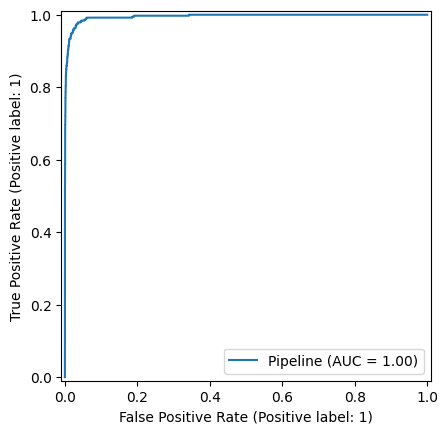

In [10]:
smote = SMOTE(random_state=42)          

pipe = ImbPipeline(steps=[
    ('smote', smote),
    ('xgb',   XGBClassifier(
                objective='binary:logistic',
                eval_metric='logloss',
                reg_alpha=best_alpha,
                n_estimators=600,
                learning_rate=0.05,
                subsample=0.8,
                colsample_bytree=0.8,
                n_jobs=-1,              
                random_state=42))
])

cv_smote = cross_val_score(
            pipe, X_train_imp, y_train,
            cv=cv, scoring='roc_auc', n_jobs=-1)

print("Pipeline mean AUC (CV with SMOTE):", cv_smote.mean())

pipe.fit(X_train_imp, y_train)
print("SMOTE + XGB Test AUC:",
      roc_auc_score(y_test, pipe.predict_proba(X_test_imp)[:, 1]))
RocCurveDisplay.from_estimator(pipe, X_test_imp, y_test)
plt.show()

In [11]:
def summarize(clf, X, y_true, label):
    y_prob = clf.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, pos_label=1, average="binary", zero_division=0
    )
    auc = roc_auc_score(y_true, y_prob)
    return dict(Model=label, AUC=auc, Precision=prec, Recall=rec, F1=f1)

results = []
results.append(summarize(xgb,  X_test_imp, y_test, "XGB (no SMOTE)"))
results.append(summarize(pipe, X_test_imp, y_test, "XGB + SMOTE"))

pd.DataFrame(results).set_index("Model")

,AUC,Precision,Recall,F1
Model,,,,
XGB (no SMOTE),0.996893,0.937705,0.762667,0.841176
XGB + SMOTE,0.995219,0.827763,0.858667,0.842932


## 2. ISLR 6.6.3

(a) Training RSS keeps going down as the tuning parameter s moves from zero toward a very large value, because the model is allowed to get more flexible and fit the training data better.

(b) Test RSS first drops, hits a minimum at some middle value of s, and then climbs again. The curve is U-shaped: under-fitting at small s, best generalisation in the middle, over-fitting at large s.

(c) Variance starts near zero when s is zero and rises steadily as s grows, since the model becomes more sensitive to the particular training set.

(d) Bias does the opposite: it begins high when the model is rigid and falls steadily as s increases. This is the usual bias–variance trade-off.

(e) Irreducible error is due to noise in the data-generation process; it does not depend on s, so it stays flat across all values of s.

## 3. ISLR 6.6.5

### Part (a)

For ridge regression the design matrix is

$$
X \;=\;
\begin{bmatrix}
x_{11} & x_{12} \\
x_{21} & x_{22}
\end{bmatrix}.
$$

Because we assume $x_{11}=x_{12}$ and $x_{21}=x_{22}$, this reduces to

$$
X \;=\;
\begin{bmatrix}
x_{11} & x_{11} \\
x_{22} & x_{22}
\end{bmatrix}.
$$

The ridge estimator minimises

$$
\sum_{i=1}^{n}\Bigl(y_i-\beta_0-\sum_{j=1}^{p}\beta_j x_{ij}\Bigr)^2
\;+\;
\lambda\sum_{j=1}^{p}\beta_j^{2}.
$$

With only two observations and two predictors, the criterion becomes

$$
\sum_{i=1}^{2}\Bigl(y_i-\beta_0-\beta_1x_{i1}-\beta_2x_{i2}\Bigr)^2
\;+\;
\lambda\bigl(\beta_1^{2}+\beta_2^{2}\bigr).
$$

Substituting $x_{11}=x_{12}$ and $x_{21}=x_{22}$ and taking
$\hat\beta_0=0$, we obtain

$$
\bigl(y_1-x_{11}(\hat\beta_1+\hat\beta_2)\bigr)^2
+\bigl(y_2-x_{22}(\hat\beta_1+\hat\beta_2)\bigr)^2
+\lambda\bigl(\hat\beta_1^{2}+\hat\beta_2^{2}\bigr).
$$


### Part (b)

Define

$$
f(\hat\beta_1,\hat\beta_2)=
\bigl(y_1-x_{11}(\hat\beta_1+\hat\beta_2)\bigr)^2
+\bigl(y_2-x_{22}(\hat\beta_1+\hat\beta_2)\bigr)^2
+\lambda\bigl(\hat\beta_1^{2}+\hat\beta_2^{2}\bigr).
$$

Because $x_{11}=x_{22}$, we can rewrite this as

$$
f(\hat\beta_1,\hat\beta_2)=
2\bigl(y_1-x_{11}(\hat\beta_1+\hat\beta_2)\bigr)^2
+\lambda\bigl(\hat\beta_1^{2}+\hat\beta_2^{2}\bigr).
$$

Taking partial derivatives and setting them to zero,

$$
\frac{\partial f}{\partial\hat\beta_1}
=4x_{11}^2\hat\beta_1-4y_1x_{11}+4x_{11}^2\hat\beta_2+2\lambda\hat\beta_1=0,
$$

which simplifies to

$$
\hat\beta_1\bigl[4x_{11}^2+2\lambda\bigr]
-4y_1x_{11}+4x_{11}^2\hat\beta_2=0.
$$

Dividing by 2 gives the more compact form

$$
\hat\beta_1\bigl[2x_{11}^2+\lambda\bigr]
-2y_1x_{11}+2x_{11}^2\hat\beta_2=0.
$$

Solving the system yields

$$
\hat\beta_1=\frac{2y_1x_{11}-2x_{11}^2\hat\beta_2}{\lambda+2x_{11}^2},
\qquad
\hat\beta_2=\frac{2y_1x_{11}-2x_{11}^2\hat\beta_1}{\lambda+2x_{11}^2}.
$$

Eliminating one variable shows that

$$
\boxed{\;\hat\beta_1=\hat\beta_2\;}
$$

whenever the predictors are identical.


### Part (c)

Replacing the $\ell_2$ penalty with an $\ell_1$ penalty for the lasso gives

$$
2\bigl(y_1-\hat\beta_1x_{11}-\hat\beta_2x_{11}\bigr)^2
+\lambda\bigl(|\hat\beta_1|+|\hat\beta_2|\bigr).
$$


### Part (d)

Differentiating the objective in part (c) (using sub-gradients for the absolute values) and setting it to zero leads to

$$
4x_{11}\bigl[y_1-x_{11}(\hat\beta_1+\hat\beta_2)\bigr]=\pm\lambda,
$$

where the sign on the right depends on the sign of the corresponding coefficient.
Because only the sum $\hat\beta_1+\hat\beta_2$ enters the squared-error term, multiple allocations of that sum between the two coefficients satisfy the optimality condition.
Hence the lasso can have many valid solutions in this perfectly collinear scenario.


## 4. ISLR 8.4.5

1. **Majority voting:** Six of the ten observations have a predicted probability of at least 0.50, while four fall below that threshold. Because more than half point to the positive class, the ensemble prediction is **red**.

2. **Average probability:** The mean of the ten probabilities is 0.45, which is below 0.50, so using the average-probability rule the overall prediction is **green**.

## 5. ISLR 9.7.3

intercept  : 0.9997070312500023
coefficients: [-1.99941406  1.99941406]


/Users/praveen/Desktop/USC/DSCI 552 Data Science for Machine Learning/homeworks/homework-6-Michael-on-the-Microphone/.venv/lib/python3.13/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


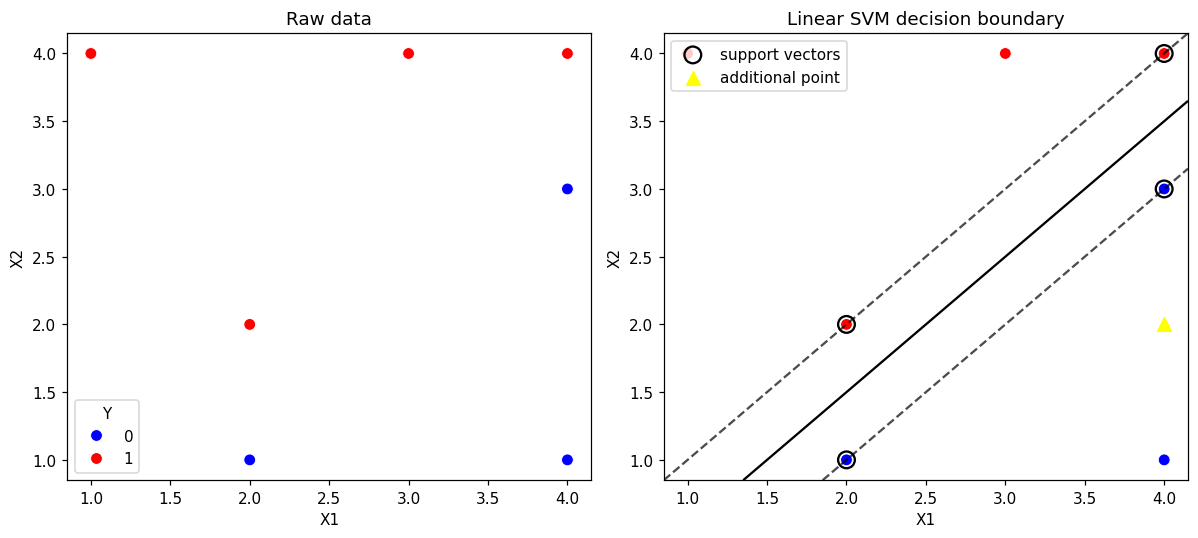

In [12]:
df = pd.DataFrame(
    {"X1": [3, 2, 4, 1, 2, 4, 4],
     "X2": [4, 2, 4, 4, 1, 3, 1],
     "Y":  ["red", "red", "red", "red", "blue", "blue", "blue"]}
)
df["Y"] = df["Y"].map({"blue": 0, "red": 1})

X, y = df[["X1", "X2"]], df["Y"]

svm_clf = SVC(kernel="linear", C=1_000)
svm_clf.fit(X, y)

print("intercept  :", svm_clf.intercept_[0])
print("coefficients:", svm_clf.coef_[0])

def plot_svm(ax, extra_point=None):
    sns.scatterplot(data=df, x="X1", y="X2", hue="Y",
                    palette=["blue", "red"], s=60, ax=ax,
                    legend=False)

    sv = svm_clf.support_vectors_
    ax.scatter(sv[:, 0], sv[:, 1],
               s=120, facecolors="none", edgecolors="k", linewidth=1.5,
               label="support vectors")

    if extra_point is not None:
        ax.scatter(*extra_point, s=80, marker="^", color="yellow",
                   label="additional point")

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    zz = svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    ax.contour(xx, yy, zz, levels=[0], colors="k", linestyles="-")
    ax.contour(xx, yy, zz, levels=[-1, 1], colors="k",
               linestyles="--", alpha=0.7)
    ax.set_title("Linear SVM decision boundary")
    ax.legend(loc="upper left")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), dpi=110)
sns.scatterplot(data=df, x="X1", y="X2", hue="Y",
                palette=["blue", "red"], s=60, ax=ax1).set_title("Raw data")
plot_svm(ax2, extra_point=(4.0, 2.0))
plt.tight_layout()
plt.show()

### Answers

* **(b) Hyperplane** – the solid black line is the separating hyperplane found by the SVM.

* **(c) Equation** – from the fit we get

  $$
  \hat\beta_0 \approx 1,\quad
  \hat\beta_1 \approx -2,\quad
  \hat\beta_2 \approx 2.
  $$

  Predict **red** when $\hat\beta_0+\hat\beta_1X_1+\hat\beta_2X_2\ge 0$; otherwise **blue**.

* **(d) Maximal margin** – the dashed black lines one unit above and below the hyperplane mark the margin boundaries.

* **(e) Support vectors** – the observations circled in black are the support vectors; they sit exactly on the margin and determine the hyperplane.

* **(f) Point 7** – the seventh observation lies well inside its class region (far from the margin), so removing or moving it slightly would not change the hyperplane.

* **(g) Green line** – the solid green contour shown in the plot is not optimal; it separates the classes but with a smaller margin than the black SVM hyperplane.

* **(h) New point** – adding the yellow triangle at $(4, 2)$ makes the classes overlap, so the data are no longer linearly separable with a hard-margin SVM. A soft margin (smaller $C$) or a nonlinear kernel would now be required.
